# Electrode recording
How to insert electrodes to measure different spiking and extracellular signals from a Brian network simulation.

Preamble:

In [1]:
import brian2.only as b2
from brian2 import np
import matplotlib.pyplot as plt
import cleo

# the default cython compilation target isn't worth it for
# this trivial example
b2.prefs.codegen.target = "numpy"
b2.seed(1919)
np.random.seed(1919)

cleo.utilities.style_plots_for_docs()

# colors
c = {
    "light": "#df87e1",
    "main": "#C500CC",
    "dark": "#8000B4",
    "exc": "#d6755e",
    "inh": "#056eee",
    "accent": "#36827F",
}

## Network setup
First we create a simple E-I network with external Poisson input and assign coordinates.
We only need spiking neurons to record {class}`~cleo.ephys.TKLFPSignal`, but we need synapses onto pyramidal cells for {class}`~cleo.ephys.RWSLFPSignalFromSpikes`.

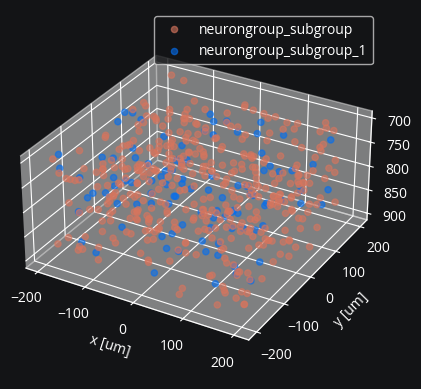

In [2]:
N = 500
n_e = int(N * 0.8)
n_i = int(N * 0.2)
n_ext = N

neurons = b2.NeuronGroup(
    N,
    "dv/dt = -v / (10*ms) : 1",
    threshold="v > 1",
    reset="v = 0",
    refractory=2 * b2.ms,
)
ext_input = b2.PoissonGroup(n_ext, 23 * b2.Hz, name="ext_input")
cleo.coords.assign_coords_rand_rect_prism(
    neurons, xlim=(-0.2, 0.2), ylim=(-0.2, 0.2), zlim=(0.7, 0.9)
)
# need to create subgroups after assigning coordinates
exc = neurons[:n_e]
inh = neurons[n_e:]

w0 = 0.06
syn_exc = b2.Synapses(
    exc,
    neurons,
    f"w = {w0} : 1",
    on_pre="v_post += w",
    name="syn_exc",
    delay=1.5 * b2.ms,
)
syn_exc.connect(p=0.1)
syn_inh = b2.Synapses(
    inh,
    neurons,
    f"w = -4*{w0} : 1",
    on_pre="v_post += w",
    name="syn_inh",
    delay=1.5 * b2.ms,
)
syn_inh.connect(p=0.1)
syn_ext = b2.Synapses(
    ext_input, neurons, "w = .05 : 1", on_pre="v_post += w", name="syn_ext"
)
syn_ext.connect(p=0.1)

net = b2.Network([neurons, exc, inh, syn_exc, syn_inh, ext_input, syn_ext])
sim = cleo.CLSimulator(net)
cleo.viz.plot(exc, inh, colors=[c["exc"], c["inh"]], scatterargs={"alpha": 0.6});

## Specifying electrode coordinates

Now we insert an electrode shank probe in the center of the population by injecting a {class}`~cleo.ephys.Probe` device.
Note that {class}`~cleo.ephys.Probe` takes arbitrary coordinates as arguments, so you can place contacts wherever you wish.
However, the {mod}`cleo.ephys` module provides convenience functions to easily generate coordinates [common in NeuroNexus probes](https://www.neuronexus.com/products/electrode-arrays/up-to-15-mm-depth#:~:text=probes%20connect%20seamlessly.-,Site%20Layout%3A,-Below%20are%20examples).
Here are some examples:


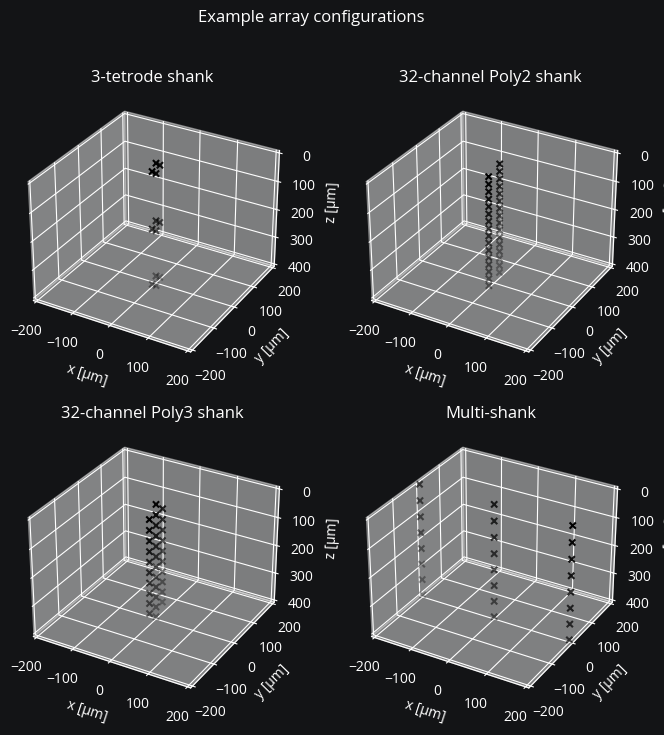

In [3]:
from cleo import ephys
from mpl_toolkits.mplot3d import Axes3D

array_length = 0.4 * b2.mm  # length of the array itself, not the shank
tetr_coords = ephys.tetrode_shank_coords(array_length, tetrode_count=3)
poly2_coords = ephys.poly2_shank_coords(
    array_length, channel_count=32, intercol_space=50 * b2.um
)
poly3_coords = ephys.poly3_shank_coords(
    array_length, channel_count=32, intercol_space=30 * b2.um
)
# by default start_location (location of first contact) is at (0, 0, 0)
single_shank = ephys.linear_shank_coords(
    array_length, channel_count=8, start_location=(-0.2, 0, 0) * b2.mm
)
# tile vector determines length and direction of tiling (repeating)
multishank = ephys.tile_coords(
    single_shank, num_tiles=3, tile_vector=(0.4, 0, 0) * b2.mm
)

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Example array configurations")
for i, (coords, title) in enumerate(
    [
        (tetr_coords, "3-tetrode shank"),
        (poly2_coords, "32-channel Poly2 shank"),
        (poly3_coords, "32-channel Poly3 shank"),
        (multishank, "Multi-shank"),
    ],
    start=1,
):
    ax = fig.add_subplot(2, 2, i, projection="3d")
    x, y, z = coords.T / b2.um
    ax.scatter(x, y, z, marker="x", c="black")
    ax.set(
        title=title,
        xlabel="x [μm]",
        ylabel="y [μm]",
        zlabel="z [μm]",
        xlim=(-200, 200),
        ylim=(-200, 200),
        zlim=(400, 0),
    )

As seen above, the {func}`~cleo.ephys.tile_coords` function can be used to repeat a single shank to produce coordinates for a multi-shank probe. Likewise it can be used to repeat multi-shank coordinates to achieve a 3D recording array (what NeuroNexus calls a [MatrixArray](https://www.neuronexus.com/products/electrode-arrays/3D-probes)).

For our example we will use a simple linear array. We configure the probe so it has 32 contacts ranging from 0.2 to 1.2 mm in depth. We could specify the orientation, but by default shank coordinates extend downwards (in the positive z direction).

We can add the electrode to the plotting function to visualize it along with the neurons:

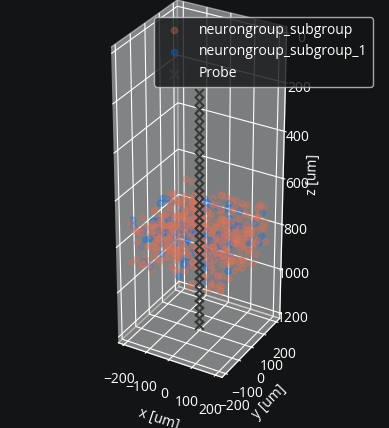

In [4]:
coords = ephys.linear_shank_coords(1 * b2.mm, 32, start_location=(0, 0, 0.2) * b2.mm)
probe = ephys.Probe(coords, save_history=True)
cleo.viz.plot(
    exc,
    inh,
    colors=[c["exc"], c["inh"]],
    zlim=(0, 1200),
    devices=[probe],
    scatterargs={"alpha": 0.3},
);

## Specifying signals to record

This looks right, but we need to specify what signals we want to pick up with our electrode.
Let's try the two basic spiking signals and an LFP approximation for point neurons.

The two spiking signals (sorted and multi-unit) take the same parameters, mainly {attr}`~cleo.ephys.Spiking.r_perfect_detection`, within which all spikes will be detected, and {attr}`~cleo.ephys.Spiking.r_half_detection`, at which distance a spike has only a 50% chance of being detected. My choice to set these parameters at 50 and 100 μm is arbitary, though from [at least some published data](https://www.frontiersin.org/articles/10.3389/fnins.2019.00385/full#F4) that seems reasonable.

We use default parameters for the [Teleńczuk kernel LFP approximation method (TKLFP)](https://www.sciencedirect.com/science/article/pii/S0165027020302946), but will need to specify cell type (excitatory or inhibitory) and sampling period (if unavailable from a connected IO processor) upon injection.

The [reference weighted sum of synaptic currents LFP proxy (RWSLFP)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584) requires synaptic currents, which we synthesize by convolving spikes with a biexponential kernel.
We need to pass in `ampa_syns` and `gaba_syns` on injection to compute the effect of incoming spikes on the population we're recording from.
We only need to do this for pyramidal cells, since RWSLFP ignores currents onto interneurons.

In [5]:
mua = ephys.MultiUnitSpiking(
    r_perfect_detection=0.05 * b2.mm,
    r_half_detection=0.1 * b2.mm,
)
ss = ephys.SortedSpiking(0.05 * b2.mm, 0.1 * b2.mm)
tklfp = ephys.TKLFPSignal()
rwslfp = ephys.RWSLFPSignalFromSpikes()

probe.add_signals(mua, ss, tklfp, rwslfp)

sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period_ms=1))
sim.inject(
    probe,
    exc,
    tklfp_type="exc",
    ampa_syns=[syn_exc[f"j < {n_e}"], syn_ext[f"j < {n_e}"]],
    gaba_syns=[syn_inh[f"j < {n_e}"]],
)
sim.inject(probe, inh, tklfp_type="inh")

CLSimulator(io_processor=RecordOnlyProcessor(sample_period_ms=1, sampling='fixed', processing='parallel'), devices={Probe(name='Probe', save_history=True, signals=[MultiUnitSpiking(name='MultiUnitSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor'>, <SpikeMonitor, recording from 'spikemonitor_6'>}, probe=..., r_perfect_detection=50. * umetre, r_half_detection=100. * umetre, cutoff_probability=0.01), SortedSpiking(name='SortedSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor_1'>, <SpikeMonitor, recording from 'spikemonitor_7'>}, probe=..., r_perfect_detection=50. * umetre, r_half_detection=100. * umetre, cutoff_probability=0.01), TKLFPSignal(name='TKLFPSignal', brian_objects={<SpikeMonitor, recording from 'spikemonitor_2'>, <SpikeMonitor, recording from 'spikemonitor_8'>}, probe=..., uLFP_threshold_uV=0.001), RWSLFPSignalFromSpikes(name='RWSLFPSignalFromSpikes', brian_objects={<SpikeMonitor, recording from 'spikemonitor_3'>, <SpikeMonitor, recording 

## Simulation and results

Now we'll run the simulation:

In [6]:
sim.run(250 * b2.ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.19s). [brian2.stateupdaters.base.method_choice]


And plot the output of the four signals we've recorded:

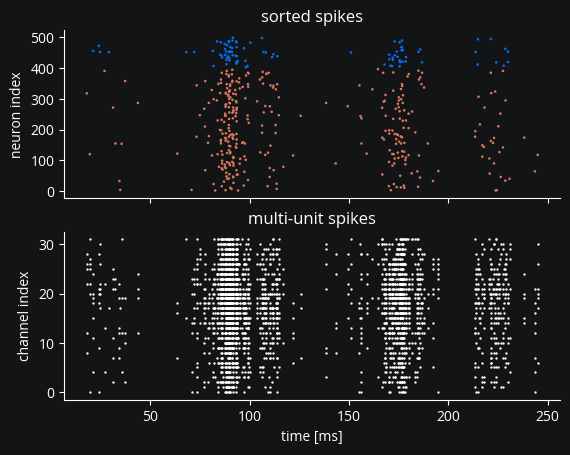

In [7]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig, axs = plt.subplots(2, 1, sharex=True)

# assuming all neurons are detectable for c=ss.i >= n_e to work
# in practice this will often not be the case and we'd have to map
# from probe index to neuron group index using ss.i_probe_by_i_ng.inverse
exc_inh_cmap = ListedColormap([c["exc"], c["inh"]])
axs[0].scatter(ss.t_ms, ss.i, marker=".", c=ss.i >= n_e, cmap=exc_inh_cmap, s=3)
axs[0].set(title="sorted spikes", ylabel="neuron index")

axs[1].scatter(mua.t_ms, mua.i, marker=".", s=2, c="white")
axs[1].set(title="multi-unit spikes", ylabel="channel index", xlabel="time [ms]");

TKLFP supposedly outputs a value with an absolute scale in terms of μV, though it is quite high compared to $\pm0.1$ μV scale of RWSLFP as given in Mazzoni, Lindén et al., 2015.
RWSLFP outputs unnormalized LFP instead of this $\pm0.1$ μV range to sidestep the complications of normalizing in a causal, stepwise manner.

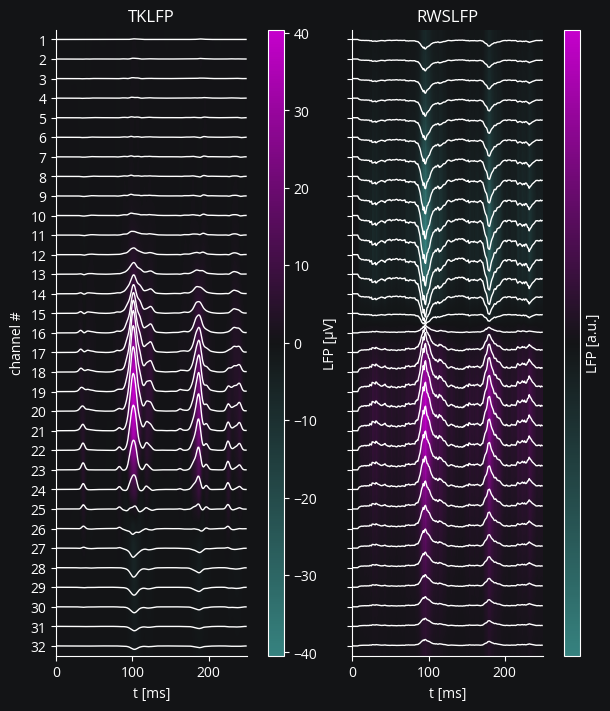

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6, 7), sharey=True, layout="constrained")
channel_offsets = -12 * np.arange(probe.n)
lfp_to_plot = tklfp.lfp_uV + channel_offsets
axs[0].plot(lfp_to_plot, color="w", lw=1)
axs[0].set(
    yticks=channel_offsets,
    yticklabels=range(1, 33),
    xlabel="t [ms]",
    ylabel="channel #",
    title="TKLFP",
)

axs[1].plot(rwslfp.lfp + channel_offsets, color="w", lw=1)
axs[1].set(title="RWSLFP", xlabel="t [ms]")

extent = (0, 250, channel_offsets.min() - 6, channel_offsets.max() + 6)
cmap = LinearSegmentedColormap.from_list("lfp", [c["accent"], "#131416", c["main"]])
im1 = axs[0].imshow(
    tklfp.lfp_uV.T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    vmin=-np.max(np.abs(tklfp.lfp_uV)),
    vmax=np.max(np.abs(tklfp.lfp_uV)),
)
fig.colorbar(im1, aspect=40, label="LFP [μV]")
im2 = axs[1].imshow(
    rwslfp.lfp.T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    vmin=-np.max(np.abs(rwslfp.lfp)),
    vmax=np.max(np.abs(rwslfp.lfp)),
)
fig.colorbar(im2, aspect=40, label="LFP [a.u.]", ticks=[]);

See {doc}`advanced_lfp` for more options and comparison of different LFP signals.